In [27]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from PIL import Image
import zipfile

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {DEVICE}")

Device used: cuda


In [28]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [29]:
def unzip_files_in_repo():
    current_dir = Path.cwd() 
    zip_files = list(current_dir.glob("*.zip")) 

    if not zip_files:
        print("No zip files found in the current directory.")
        return

    for zip_file in zip_files:
        print(f"Processing {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            target_dir = current_dir
            target_dir.mkdir(exist_ok=True)

            zip_ref.extractall(target_dir)
        print(f"Extracted {zip_file} to {target_dir}")

In [30]:
unzip_files_in_repo()

Processing /home/melon/studia/animal_classification_nn/out_of_domain_samples.zip...
Extracted /home/melon/studia/animal_classification_nn/out_of_domain_samples.zip to /home/melon/studia/animal_classification_nn
Processing /home/melon/studia/animal_classification_nn/real_world_samples.zip...
Extracted /home/melon/studia/animal_classification_nn/real_world_samples.zip to /home/melon/studia/animal_classification_nn


In [31]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 7

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        #self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)

        self.fc1 = nn.Linear(in_features = 32 * 8 * 8, out_features = 256)
        self.fc2 = nn.Linear(in_features = 256, out_features=3)

    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        #x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [33]:
def init_model(model_name):
    match model_name:
        case "EfficientNet_B0":
            weights = models.EfficientNet_B0_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.efficientnet_b0(weights=weights)
            num_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_features, 3) 
            LEARNING_RATE = 0.001
        case "ResNet50":
            weights = models.ResNet50_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.resnet50()
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 3)
            LEARNING_RATE = 0.0001
        case "CNN":
            model = CNN()
            data_transform = transforms.Compose([
                    transforms.Resize((128, 128)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
            LEARNING_RATE = 0.001
        case _:
            raise ValueError(f"Model {model_name} is not supported.")
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    return model, data_transform, criterion, optimizer

In [34]:
def init_dataloaders(train_path, test_path, data_transform, val_ratio = 0.1):
    train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)
    classes = train_dataset.classes
    val_size = int(val_ratio * len(train_dataset))
    train_size = len(train_dataset) - val_size

    set_seed(42)
    val_dataset, train_dataset = random_split(train_dataset, [val_size, train_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, classes

In [35]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    best_val_accuracy = 0

    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = accuracy_score(all_labels, all_preds)

        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)

        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
    
    with open(f'{model_name}_history.json', 'w') as f:
        json.dump(history, f)

    print(f"Training complete for {model_name}. Training stats saved to '{model_name}_history.json'.")

In [36]:
model_names = ["EfficientNet_B0", "ResNet50", "CNN"]

In [37]:
train_path = 'data/afhq/train'
test_path = 'data/afhq/val'

train_loader_classes = {}
test_loaders = {}

for model_name in model_names:
    print(f"Initializing and training model: {model_name}")
    
    model, data_transform, criterion, optimizer = init_model(model_name)
    train_loader, val_loader, test_loader, classes = init_dataloaders(train_path, test_path, data_transform, val_ratio=0.1)

    train_loader_classes[model_name] = classes
    test_loaders[model_name] = test_loader
    
    train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)

Initializing and training model: EfficientNet_B0


Training Epoch 1/7: 100%|██████████| 412/412 [01:50<00:00,  3.73it/s]


Epoch [1/7], Train Loss: 0.0656, Train Accuracy: 0.9798, Val Loss: 0.0196, Val Accuracy: 0.9945


Training Epoch 2/7: 100%|██████████| 412/412 [01:42<00:00,  4.03it/s]


Epoch [2/7], Train Loss: 0.0257, Train Accuracy: 0.9921, Val Loss: 0.0182, Val Accuracy: 0.9945


Training Epoch 3/7: 100%|██████████| 412/412 [01:41<00:00,  4.08it/s]


Epoch [3/7], Train Loss: 0.0172, Train Accuracy: 0.9950, Val Loss: 0.0133, Val Accuracy: 0.9979


Training Epoch 4/7: 100%|██████████| 412/412 [01:41<00:00,  4.05it/s]


Epoch [4/7], Train Loss: 0.0133, Train Accuracy: 0.9957, Val Loss: 0.0116, Val Accuracy: 0.9979


Training Epoch 5/7: 100%|██████████| 412/412 [01:42<00:00,  4.01it/s]


Epoch [5/7], Train Loss: 0.0128, Train Accuracy: 0.9958, Val Loss: 0.0133, Val Accuracy: 0.9986


Training Epoch 6/7: 100%|██████████| 412/412 [01:43<00:00,  4.00it/s]


Epoch [6/7], Train Loss: 0.0087, Train Accuracy: 0.9974, Val Loss: 0.0147, Val Accuracy: 0.9959


Training Epoch 7/7: 100%|██████████| 412/412 [01:42<00:00,  4.03it/s]


Epoch [7/7], Train Loss: 0.0082, Train Accuracy: 0.9976, Val Loss: 0.0391, Val Accuracy: 0.9904
Training complete for EfficientNet_B0. Training stats saved to 'EfficientNet_B0_history.json'.
Initializing and training model: ResNet50


Training Epoch 1/7: 100%|██████████| 412/412 [02:05<00:00,  3.28it/s]


Epoch [1/7], Train Loss: 0.7014, Train Accuracy: 0.6753, Val Loss: 0.4210, Val Accuracy: 0.8360


Training Epoch 2/7: 100%|██████████| 412/412 [02:02<00:00,  3.35it/s]


Epoch [2/7], Train Loss: 0.3263, Train Accuracy: 0.8732, Val Loss: 0.2288, Val Accuracy: 0.9105


Training Epoch 3/7: 100%|██████████| 412/412 [02:01<00:00,  3.40it/s]


Epoch [3/7], Train Loss: 0.2137, Train Accuracy: 0.9224, Val Loss: 0.2270, Val Accuracy: 0.9180


Training Epoch 4/7: 100%|██████████| 412/412 [02:01<00:00,  3.39it/s]


Epoch [4/7], Train Loss: 0.1473, Train Accuracy: 0.9457, Val Loss: 0.1718, Val Accuracy: 0.9371


Training Epoch 5/7: 100%|██████████| 412/412 [02:01<00:00,  3.39it/s]


Epoch [5/7], Train Loss: 0.1128, Train Accuracy: 0.9598, Val Loss: 0.3459, Val Accuracy: 0.8852


Training Epoch 6/7: 100%|██████████| 412/412 [02:01<00:00,  3.38it/s]


Epoch [6/7], Train Loss: 0.0817, Train Accuracy: 0.9711, Val Loss: 0.1669, Val Accuracy: 0.9412


Training Epoch 7/7: 100%|██████████| 412/412 [02:00<00:00,  3.41it/s]


Epoch [7/7], Train Loss: 0.0661, Train Accuracy: 0.9761, Val Loss: 0.1518, Val Accuracy: 0.9405
Training complete for ResNet50. Training stats saved to 'ResNet50_history.json'.
Initializing and training model: CNN


Training Epoch 1/7: 100%|██████████| 412/412 [00:55<00:00,  7.38it/s]


Epoch [1/7], Train Loss: 0.3711, Train Accuracy: 0.8464, Val Loss: 0.2571, Val Accuracy: 0.8941


Training Epoch 2/7: 100%|██████████| 412/412 [01:01<00:00,  6.74it/s]


Epoch [2/7], Train Loss: 0.1468, Train Accuracy: 0.9455, Val Loss: 0.1334, Val Accuracy: 0.9460


Training Epoch 3/7: 100%|██████████| 412/412 [01:00<00:00,  6.79it/s]


Epoch [3/7], Train Loss: 0.0976, Train Accuracy: 0.9653, Val Loss: 0.1209, Val Accuracy: 0.9508


Training Epoch 4/7: 100%|██████████| 412/412 [00:59<00:00,  6.89it/s]


Epoch [4/7], Train Loss: 0.0744, Train Accuracy: 0.9733, Val Loss: 0.1094, Val Accuracy: 0.9604


Training Epoch 5/7: 100%|██████████| 412/412 [01:01<00:00,  6.70it/s]


Epoch [5/7], Train Loss: 0.0623, Train Accuracy: 0.9774, Val Loss: 0.0933, Val Accuracy: 0.9658


Training Epoch 6/7: 100%|██████████| 412/412 [01:05<00:00,  6.29it/s]


Epoch [6/7], Train Loss: 0.0418, Train Accuracy: 0.9842, Val Loss: 0.1463, Val Accuracy: 0.9522


Training Epoch 7/7: 100%|██████████| 412/412 [01:05<00:00,  6.34it/s]


Epoch [7/7], Train Loss: 0.0345, Train Accuracy: 0.9867, Val Loss: 0.0957, Val Accuracy: 0.9686
Training complete for CNN. Training stats saved to 'CNN_history.json'.


In [38]:
def plot_metrics_from_json(model_names):

    all_train_loss = {}
    all_val_loss = {}
    all_train_acc = {}
    all_val_acc = {}

    for model_name in model_names:
        json_path = f'{model_name}_history.json'
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        all_train_loss[model_name] = data['train_loss']
        all_val_loss[model_name] = data['val_loss']
        all_train_acc[model_name] = data['train_accuracy']
        all_val_acc[model_name] = data['val_accuracy']

    colors = ['b', 'g', 'r']

    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_loss[model_name], label=f'{model_name} Train Loss', color=color)
        plt.plot(all_val_loss[model_name], label=f'{model_name} Val Loss', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy (Training and Validation) for all models
    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_acc[model_name], label=f'{model_name} Train Acc', color=color)
        plt.plot(all_val_acc[model_name], label=f'{model_name} Val Acc', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

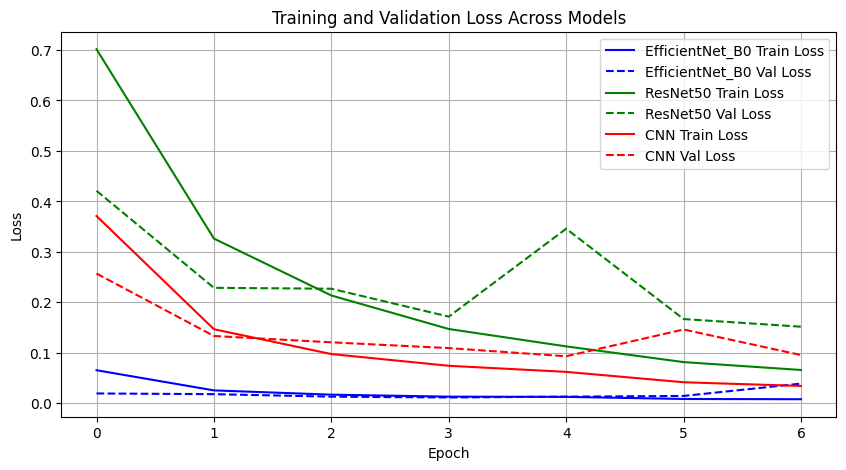

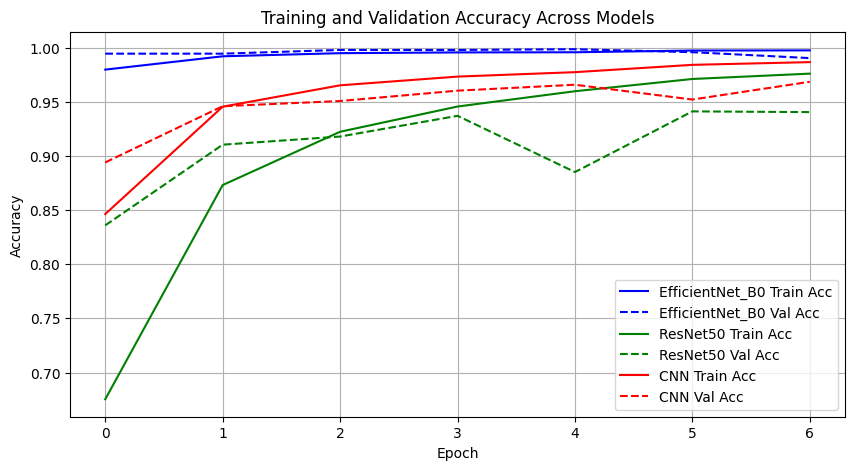

In [39]:
plot_metrics_from_json(model_names)

In [40]:
def test_model(model, model_name, test_loader):
    model.eval()

    test_preds = []
    test_labels = []
    with torch.inference_mode():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Model"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy().tolist())
            test_labels.extend(labels.cpu().numpy().tolist())

    results = {
        "test_labels": [test_labels],
        "test_preds": [test_preds]
    }

    with open(f"{model_name}_predictions.json", "w") as f:
        json.dump(results, f)

    print(f"Predictions and labels saved to {model_name}_predictions.json")
    return test_labels, test_preds

In [41]:
for model_name in model_names:
    print(f"Loading and testing model: {model_name}")
    
    model, _, _, _ = init_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth", weights_only=True, map_location=DEVICE))

    test_loader = test_loaders[model_name]
    test_model(model, model_name, test_loader)

Loading and testing model: EfficientNet_B0


Evaluating Model: 100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


Predictions and labels saved to EfficientNet_B0_predictions.json
Loading and testing model: ResNet50


Evaluating Model: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


Predictions and labels saved to ResNet50_predictions.json
Loading and testing model: CNN


Evaluating Model: 100%|██████████| 47/47 [00:04<00:00, 11.19it/s]

Predictions and labels saved to CNN_predictions.json


In [42]:
def get_metrics(test_labels, test_preds, model_name):

    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    f1 = f1_score(test_labels, test_preds, average='weighted')
    cm = confusion_matrix(test_labels, test_preds)
    
    return cm, {
        "Model": model_name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    }

In [43]:
def show_cm(cm, model_name, classes):
    
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [44]:
classes = ['cat', 'dog', 'wildlife']
all_metrics = []
all_cms = []
for model_name in model_names:
    with open(f'{model_name}_predictions.json', 'r') as f:
        data = json.load(f)
    test_labels = np.array(data['test_labels']).flatten().tolist()
    test_preds = np.array(data['test_preds']).flatten().tolist()
    # classes = train_loader_classes[model_name]
    cm, metrics = get_metrics(test_labels, test_preds, model_name)
    all_metrics.append(metrics)
    all_cms.append(cm)

metrics_df = pd.DataFrame(all_metrics)



In [45]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,EfficientNet_B0,0.9933,0.9934,0.9933,0.9933
1,ResNet50,0.9360,0.9407,0.9360,0.9361
2,CNN,0.9660,0.9665,0.9660,0.9660


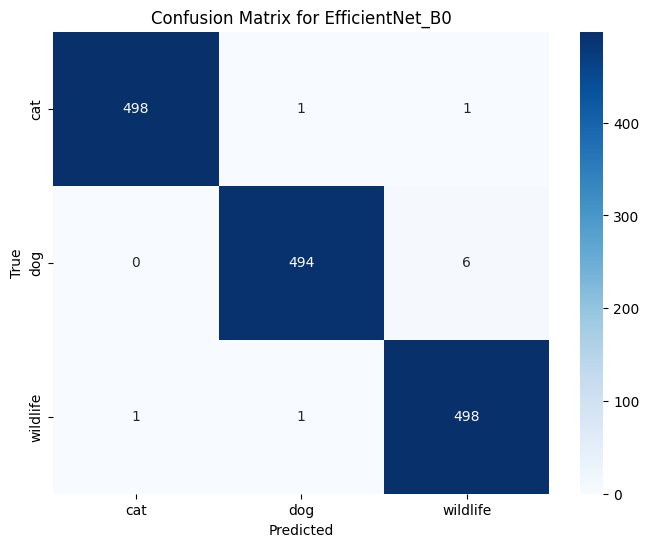

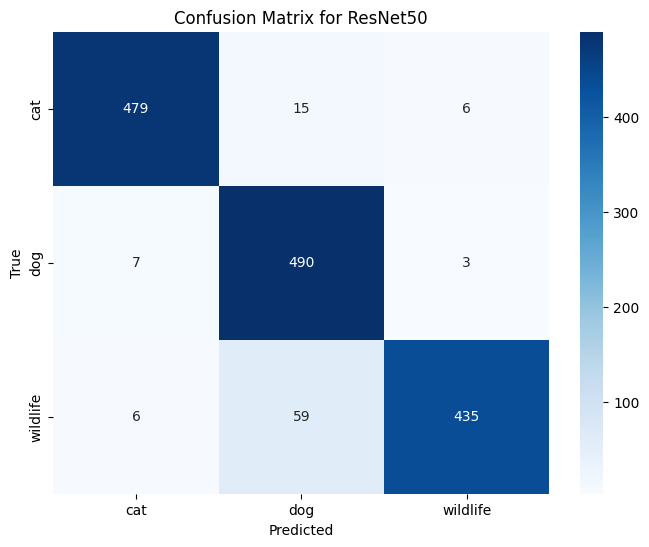

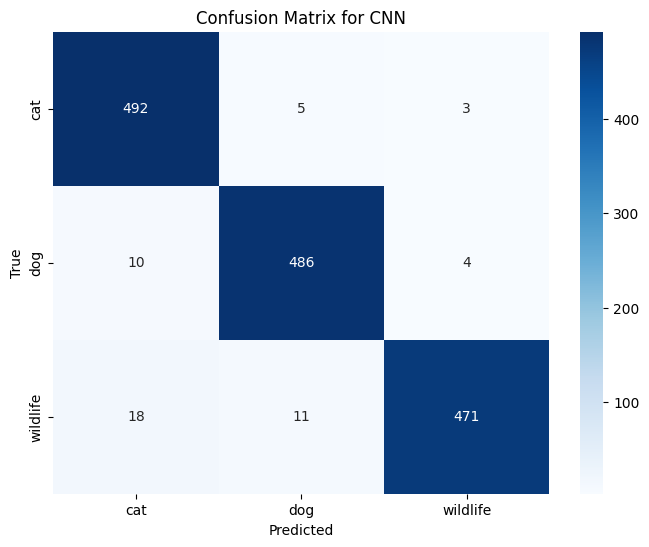

In [46]:
classes = ['cat', 'dog', 'wildlife']
for idx, model_name in enumerate(model_names):
    show_cm(all_cms[idx], model_name, classes)

## Real life samples test

In [47]:
model_names = ["EfficientNet_B0", "ResNet50", "CNN"]
rl_test_path = "./real_world_samples"

In [48]:
for model_name in model_names:
    print(f"Loading and testing model: {model_name}")
    
    model, data_transform, _, _ = init_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth", weights_only=True, map_location=DEVICE))

    model_name += "_real_life"
    rl_test_dataset = datasets.ImageFolder(root=rl_test_path, transform=data_transform)
    rl_test_loader = DataLoader(rl_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    test_model(model, model_name, rl_test_loader)

Loading and testing model: EfficientNet_B0


Evaluating Model: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Predictions and labels saved to EfficientNet_B0_real_life_predictions.json
Loading and testing model: ResNet50


Evaluating Model: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Predictions and labels saved to ResNet50_real_life_predictions.json
Loading and testing model: CNN


Evaluating Model: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]

Predictions and labels saved to CNN_real_life_predictions.json


In [49]:
classes = ['cat', 'dog', 'wildlife']
all_metrics = []
all_cms = []
for model_name in model_names:
    with open(f'{model_name}_predictions.json', 'r') as f:
        data = json.load(f)
    test_labels = np.array(data['test_labels']).flatten().tolist()
    test_preds = np.array(data['test_preds']).flatten().tolist()
    # classes = train_loader_classes[model_name]
    cm, metrics = get_metrics(test_labels, test_preds, model_name)
    all_metrics.append(metrics)
    all_cms.append(cm)

rl_metrics_df = pd.DataFrame(all_metrics)

In [50]:
rl_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,EfficientNet_B0,0.9933,0.9934,0.9933,0.9933
1,ResNet50,0.9360,0.9407,0.9360,0.9361
2,CNN,0.9660,0.9665,0.9660,0.9660


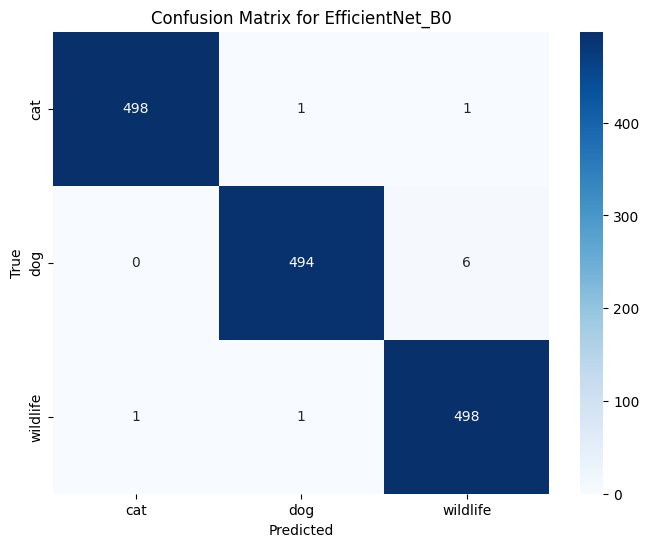

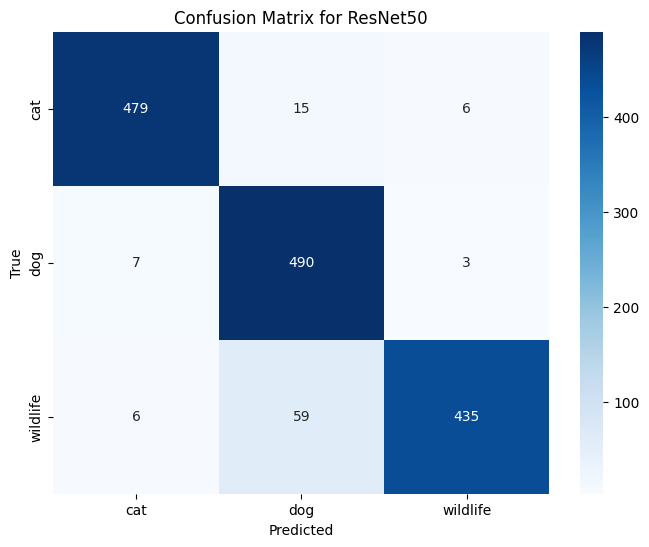

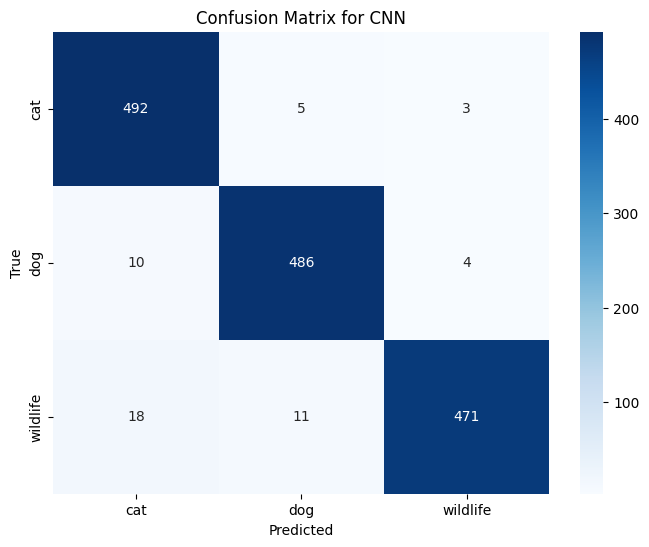

In [51]:
classes = ['cat', 'dog', 'wildlife']
for idx, model_name in enumerate(model_names):
    show_cm(all_cms[idx], model_name, classes)

## Out of domain testing

In [52]:
def plot_prediction_histogram(results, model_name):
    df = pd.DataFrame({
        "Image": results["files"],
        "Prediction": results["predictions"]
    })

    plt.figure(figsize=(10, 6))
    df["Prediction"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"Prediction Distribution for OOD Images ({model_name})")
    plt.xlabel("Predicted Class")
    plt.ylabel("Number of Images")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

In [53]:
def test_models_on_ood(model_names, ood_path):
    ood_path = Path(ood_path)

    classes = ['cat', 'dog', 'wildlife']  # Update based on your trained classes

    for model_name in model_names:
        print(f"Processing OOD samples for model: {model_name}")

        # Initialize model and transformations
        model, data_transform, _, _ = init_model(model_name)
        model.load_state_dict(torch.load(f"{model_name}_best_model.pth", weights_only=True, map_location=DEVICE))
        model.eval()

        # Collect predictions
        ood_results = {"files": [], "predictions": []}
        ood_files = list(ood_path.glob("*.*"))  # Match all files in OOD folder
        with torch.inference_mode():
            for img_path in tqdm(ood_files, desc=f"Evaluating OOD for {model_name}"):
                try:
                    # Load and preprocess image
                    image = Image.open(img_path).convert("RGB")
                    image_tensor = data_transform(image).unsqueeze(0).to(DEVICE)

                    # Perform inference
                    output = model(image_tensor)
                    _, pred_class = torch.max(output, 1)

                    # Store predictions
                    ood_results["files"].append(str(img_path))
                    ood_results["predictions"].append(classes[pred_class.item()])
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

        # Save results
        result_file = f"{model_name}_ood_results.json"
        with open(result_file, "w") as f:
            json.dump(ood_results, f)
        print(f"Results saved to {result_file}")

        plot_prediction_histogram(ood_results, model_name)

Processing OOD samples for model: EfficientNet_B0


Evaluating OOD for EfficientNet_B0: 100%|██████████| 50/50 [00:00<00:00, 80.14it/s]


Results saved to EfficientNet_B0_ood_results.json


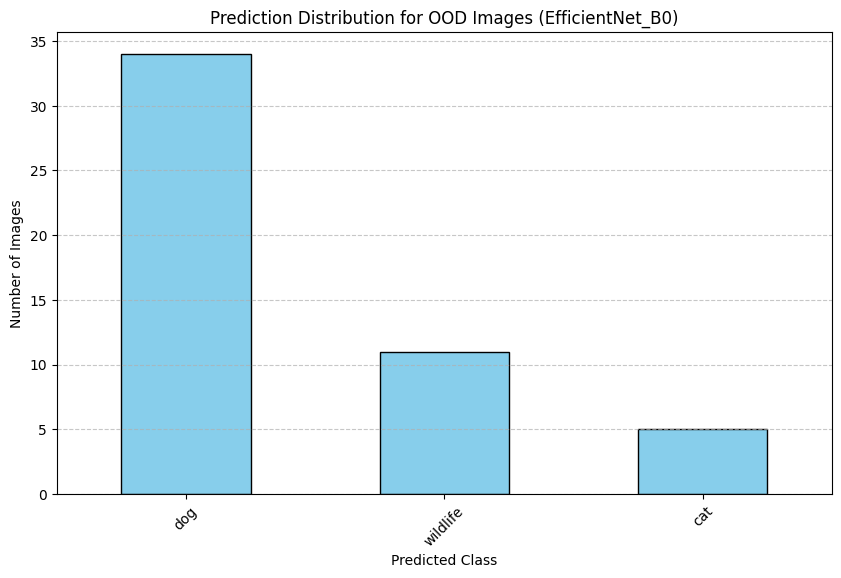

Processing OOD samples for model: ResNet50


Evaluating OOD for ResNet50: 100%|██████████| 50/50 [00:00<00:00, 95.87it/s] 

Results saved to ResNet50_ood_results.json


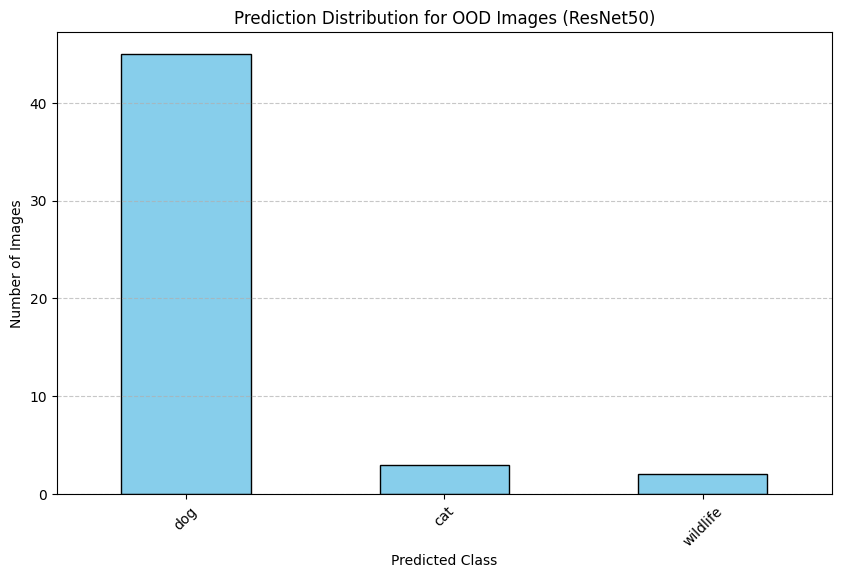

Processing OOD samples for model: CNN


Evaluating OOD for CNN: 100%|██████████| 50/50 [00:00<00:00, 296.23it/s]

Results saved to CNN_ood_results.json


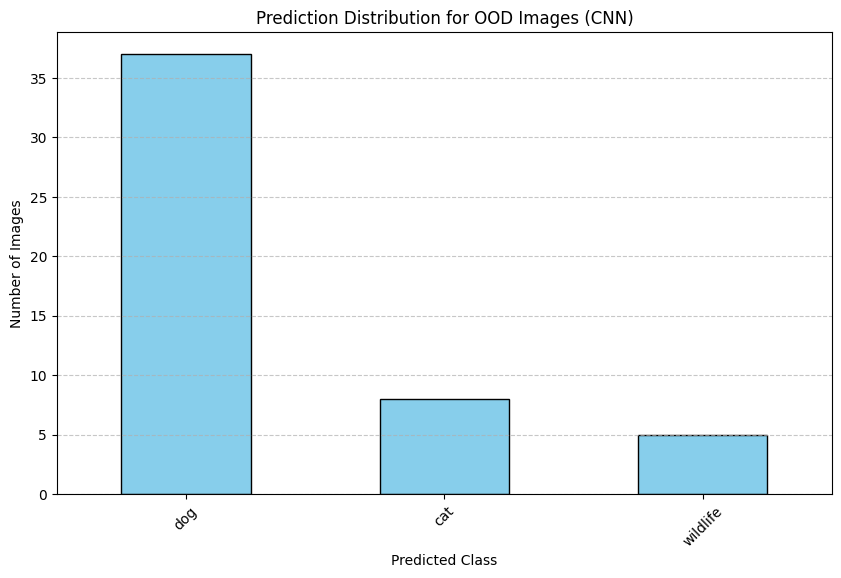

In [54]:
ood_path = "./out_of_domain_samples"
model_names = ["EfficientNet_B0", "ResNet50", "CNN"]

test_models_on_ood(model_names, ood_path)